# The Epistemology of Deep Learning
## Week 2: Introduction to Neural Networks and Machine Learning
Modern research into the development of neural networks has advanced at a remarkable pace in recent years. This research has led to the advent of increasingly sophisticated neural networks which can vastly outperform their now outdated counterparts. Here, for example, is a diagram depicting the underlying architecture of the neural network that has achieved the current state-of-the-art results with respect to various image recognition applications:

![rmdl_example](../assets/images/mnist/rmdl_example.png)

Despite the dizzying complexity of modern neural networks, as we shall see, the underlying principles on which they operate are relatively straightforward (we will later consider, in more detail, what all this added complexity is meant to achieve).

## Implementing a Simple Neural Network
### Example 1: Linear Inference

To get a better understanding of the way that neural networks process data, we will begin by implementing a very simple network and train it to perform a basic task. The neural network that we will implement will be able to predict, for any arbitrary point in a 2-d region, how far above or below that point is from a fixed dividing line. The catch here is that we will not tell the network where the dividing line is. Instead, the network will have to infer the location of the dividing line by analyzing a dataset consisting of randomly chosen points and their vertical displacements. 


In [1]:
import random

def points_dataset(func, size, binary=False):
    """Generate a dataset of points 
    labeled by a given function"""
    points = np.random.rand(size, 2)
    vals = np.array([func(point) for point in points])
    return points, vals   

class Dividing_Line:
    """Dividing Line"""
    def __init__(self, slope, y_offset):
        self.slope = slope
        self.offest = y_offset
        self.func = lambda x : (x * slope) + y_offset
        self.points = []
        self.vals = []
        
    def displacement(self, point):
        x = point[0]
        y = point[1]
        return (y - self.func(x))
    
    def generate_point_dataset(self, size):
        for i in range(size):
            # Choose a random point
            point = [random.random(), random.random()]
            val = self.displacement(point)
            self.points.append(point)
            self.vals.append(val)
    
    def plot(self):
        domain = np.arange(0, 1.01, 0.01)
        fig, axes = plt.subplots(figsize=(8, 6), dpi=80)
        axes.set_xlim(0, 1)
        axes.set_ylim(0, 1)
        # plot line
        axes.plot(domain, self.func(domain))
        # generate points dataset
        xvals = np.array([point[0] for point in self.points])
        yvals = np.array([point[1] for point in self.points])
        axes.scatter(xvals, yvals, c=np.array(self.vals))
        plt.show        

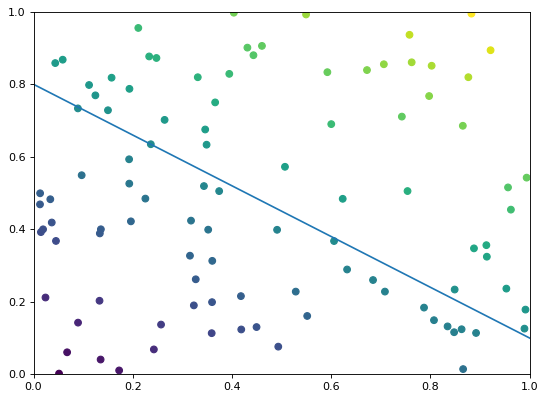

In [2]:
# Sample Linear Separation
sample_line = Dividing_Line(-0.7, 0.8) # slope = -0.7, y-offset = 0.8
sample_line.generate_point_dataset(100) # generate 200 random points
sample_line.plot() # plot the points indicating how far above or below the dividing line they fall

Our neural network will consist of two layers: an input layer consisting of two linearly ordered neurons and an output layer consisting of a single neuron. Each of the input neurons in the network will be connected to the output neuron via a link. The graph of such a neural network is pictured below:

![nn_2_1](../assets/images/mnist/nn_2_1.png)

The internal state of this neural network, at any point in time, is given by an assignment of numerical values, referred to as *weights*, to each of the links in the network, and a separate number referred to as the *bias* of the network. The weights and the bias of the network determine how a given assignment of numerical values to the neurons in the input layer propagate through the network. As a result of this propagation a numerical value ultimately gets assigned to the neuron in the output layer. When we utilize this network for the purpose of linear inference, the input values will represent the coordinates of a given point, and the output value will represent the network's best guess as to how far the point is displaced above or below the dividing line. 


Let $v_1$ be the value of the first neuron in the input layer; $v_2$ the value of the second neuron in the input layer; $w_1$ the weight of the link connecting the first input neuron to the output neuron; $w_2$ the weight of the link connecting the second input neuron to the output neuron; and $b$ the network's bias. Then the propagation algorithm determining the value of the output neuron, $o$, is given as follows:

$$ 
o(v_1,v_2) = (v_1 \times w_1) + (v_2\times w_2) + b
$$

In [3]:
def propagate(input_1, input_2, weight_1, weight_2, bias):
    """Propagate input values through the neural network"""
    return (input_1 * weight_1) + (input_2 * weight_2) + bias

We want to train our neural network to make accurate predictions about the vertical displacements of points above or below an unknown dividing line. When we speak of 'training' the neural network, what we mean is the implementation of an algorithmic procedure by which the weights and bias of the network are systematically adjusted in response to a given set of data so as to bring it about that inputs supplied to the network produce more accurate outputs. In this case, we will train our network by allowing it to observe a number of points, one after another, and adjusting its weights and bias in response to how far the observed point falls above or below the unknown dividing line. 

Here is the specific 'training' algorithm that we will use to update the weights and bias of the network in response to the data:

1. Select a data point $(x,y)$. Let $l(x,y)$ be the actual (target) vertical displacement of this point from the unknown dividing line (we will assume that the dataset supplies us with this information).  
2. Propagate the coordinates of the point through the network by computing the value $o(x,y)$.
3. Update the weights and bias of the network from their current values ($w_1, w_2,$ and $b$) to new values ($w_1', w_2'$, and $b'$) as follows:
$$ \Delta(x,y) = o(x,y)-l(x,y)$$
$$ w_1' =  w_1 - \alpha x\Delta(x,y)$$
$$ w_2' = w_2 - \alpha y\Delta(x,y)$$
$$ b' = b - \alpha\Delta(x,y)$$ 
Here, $\alpha$ is a constant, referred to as the 'learning rate'. 
5. Repeat the process (starting with Step 1) until all the data points have been processed.

For now, don't worry about the rationale behind this algorithm. We'll talk about how to conceptualize it in more detail a bit later on. Here is a function that implements the crucial updating step of this training algorithm (Step 3 above):

In [4]:
def update_network(x, y, weight_1, weight_2, bias, target, alpha):
    """Update weights and bias"""
    # Propagate the inputs throught the network
    output = propagate(x, y, weight_1, weight_2, bias)
    # Compute the difference between the network's prediction and the target displacement
    delta = output - target
    # Adjust the weights and bias according to the above algorithm
    weight_1 -= alpha * x * delta # w_1' = w_1' - a * x * delta
    weight_2 -= alpha * y * delta
    bias -= alpha * delta
    # Return the updated weights and the update bias
    return weight_1, weight_2, bias

Now, we can write a function that implements the entire neural network training algorithm. In training the network, we will keep track of the changes to the network's state (i.e., the changes to its weights and its bias) so we can examine how the state of the network evolved throughout the training process. 

In [5]:
def train_network(training_inputs, initial_weight_1, initial_weight_2, initial_bias, training_targets, alpha):
    """Train the neural network using the training algorithm"""
    # Initialize weights and bias
    weight_1 = initial_weight_1
    weight_2 = initial_weight_2
    bias = initial_bias
    # Initialize training log
    training_log = [[weight_1, weight_2, bias]]
    # Update weights and bias for each training input
    for t in range(len(training_inputs)):
        x = training_inputs[t][0]
        y = training_inputs[t][1]
        target = training_targets[t]
        # update the network weights and bias
        weight_1, weight_2, bias = update_network(x, y, weight_1, weight_2, bias, target, alpha)
        # update the training log
        training_log.append([weight_1, weight_2, bias])
    
    # The fully trained_network! 
    def trained_network(input_1, input_2):
        return propagate(input_1, input_2, weight_1, weight_2, bias)
    
    # Return the trained neural network and the training log
    return trained_network, training_log         

We will train our network using a dataset of $500$ randomly chosen points along with their vertical displacements from a target dividing line. 

In [6]:
target_line = Dividing_Line(-1.8, 0.6) # slope = -1.8, y-offset = 0.6
target_line.generate_point_dataset(500) # generate 500 random points

The data that we will use to train the network looks like this:

,x,y,Offset
0,0.992776,0.425027,1.612024
1,0.015066,0.850361,0.277479
2,0.526683,0.398591,0.746621
3,0.419617,0.837390,0.992701
4,0.409736,0.955412,1.092936
...,...,...,...
495,0.508041,0.606210,0.920684
496,0.326848,0.890863,0.879190
497,0.787748,0.339063,1.157009
498,0.379877,0.088548,0.172327


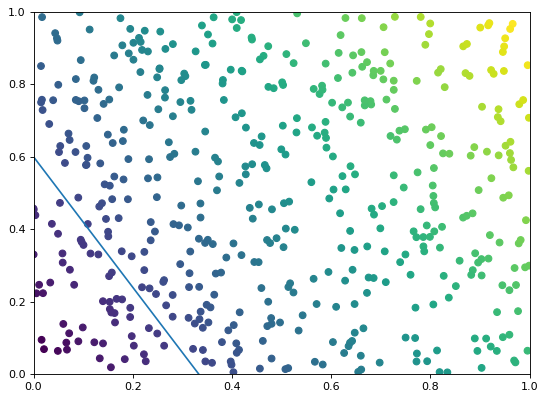

In [7]:
target_line.plot() # plot the points indicating how far above or below the dividing line they fall
target_data = [[target_line.points[i][0], target_line.points[i][1], target_line.vals[i]] for i in range(len(target_line.points))]
pd.DataFrame(target_data, columns=['x', 'y', 'Offset'])

Now, let's train our first neural network! 

In [8]:
# Initialize the network state and set the learning rate
initial_weight_1 = -1
initial_weight_2 = 1
initial_bias = 0
alpha = 1

# Train the network
neural_network, training_log = train_network(target_line.points,
                                    initial_weight_1, 
                                    initial_weight_2,
                                    initial_bias,
                                    target_line.vals,
                                    alpha)

The variable `neural_network` now stores our fully trained neural network. Here, the network is represented as a black-box function which takes two inputs and returns an output. The weights and bias of the network can be found by looking at the last entry of the record stored in the variable `training_log`. 

In [9]:
training_log[-1]

[1.8000000000001362, 1.000000000000029, -0.6000000000002629]

So, the weights of the fully trained network are about $1.8$ and $1.0$, respectively, and the bias of the network is about $-0.6$. 

Recall that the propagation algorithm for the network is given by:
$$ 
o = (v_1 \times w_1) + (v_2\times w_2) + b
$$

This can be rewritten as follows:

$$
v_2 = -\left(\frac{w_1}{w_2}\right)v_1 - \left(\frac{b}{w_2}\right) + \left(\frac{o}{w_2}\right)
$$

Thus, the internal state of our neural network can be thought of as encoding the position of a dividing line. That is, the input values $v_1$ and $v_2$, when propagated through the network, yield the value $o$  just in case the point $(v_1,v_2)$ is displaced by an amount $\left(\frac{o}{w_2}\right)$ above or below the dividing line given by:

$$
y = -\left(\frac{w_1}{w_2}\right)x - \left(\frac{b}{w_2}\right)
$$

In the case of our fully trained network, the network encodes the dividing line given by:
$$
y =  -\left(\frac{w_1}{w_2}\right)x - \left(\frac{b}{w_2}\right) = -\left(\frac{1.8}{1.0}\right)x - \left(-\frac{0.6}{1.0}\right) = -1.8x + 0.6
$$

This is exactly the dividing line that we used to generate the data! So, it looks like the training algorithm worked. It allowed our network to correctly infer the position of the dividing line by analyzing the data. The following code confirms this by displaying a visualization of how the dividing line encoded by the state of the neural network grows increasingly close to the target dividing line as the training progresses. 

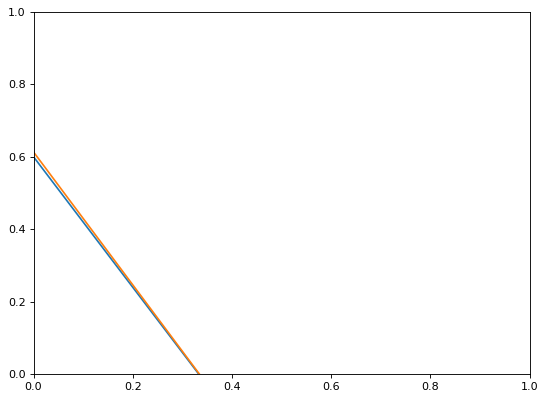

In [11]:
from matplotlib import animation, rc
from IPython.display import HTML

def animate_training_log(training_log):
    """Animate Training Log"""

    def line_from_log(i):
        "Get the function for the line predicted in the ith entry of the log"
        slope = -(training_log[i][0] / training_log[i][1])
        y_offset = -(training_log[i][2] / training_log[i][1])
        return lambda x : (x * slope) + y_offset
    
    domain = np.arange(0, 1.01, 0.01)
    fig, axes = plt.subplots(figsize=(8, 6), dpi=80)
    axes.set_xlim(0, 1)
    axes.set_ylim(0, 1)
    axes.plot(domain, target_line.func(domain))
    line, = axes.plot(domain, line_from_log(0)(domain))
    
    def animate(i):
        func = line_from_log(i)
        line.set_ydata(func(domain))
        return line,
    
    anim = animation.FuncAnimation(fig, animate, interval=200, blit=True)
    HTML(anim.to_html5_video())
    
animate_training_log(training_log)

### The XOR Problem

The neural network that we have just implemented is closely related to the original 'perceptron' model discussed by Minsky and Papert (1969). The only difference between our neural network and a perceptron is that the propagation algorithm for a perceptron feeds the value of the output neuron through a 'step' function, so that the network always outputs either $1$ or $0$. More specifically, the propagation algorithm for the perceptron is given by:

$$ 
o(v_1,v_2) = \left\{\begin{array}{ll} 1 & \textrm{if }(v_1 \times w_1) + (v_2\times w_2) + b > 0\\ 0 & \textrm{if }(v_1 \times w_1) + (v_2\times w_2) + b \leq 0\end{array}\right.
$$

In [13]:
def propagate(input_1, input_2, weight_1, weight_2, bias):
    """Propagate input values through the perceptron"""
    return 1 if ((input_1 * weight_1) + (input_2 * weight_2) + bias > 0) else 0

Let us now reflect, for a moment, on the capabilities and limits of such a neural network. As was the case with our neural network, every perceptron can be thought of encoding a dividing line. The quantity $o$ measures whether or not the point whose coordinates are given by the inputted values falls above or below the encoded line (if $w_2 \geq 0$, then $1$=above and $0$=on or below; if $w_2 < 0$, then $0$=above and $1$=on or below). A perceptron can thus be trained to perform all and only those tasks which can be reduced to answering questions of the form: does a given point fall above or below a certain line? 

Suppose, for example, that the inputs to the perceptron can take one of two values, either $0$ or $1$. Can the perceptron infer from a data set that its output should be $1$ just in case both of its inputs are $1$? The answer, it seems, should be yes since this task is equivalent to the task of determining whether a point appearing in one of the following four positions falls above or below the indicated line:

<function matplotlib.pyplot.show(close=None, block=None)>

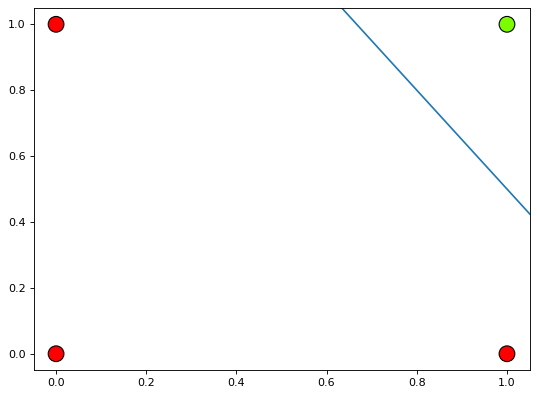

In [14]:
domain = np.arange(-2, 2, 0.01)
fig, axes = plt.subplots(figsize=(8, 6), dpi=80)
axes.set_xlim(-0.05, 1.05)
axes.set_ylim(-0.05, 1.05)
# generate points dataset
xvals = np.array([1, 1, 0, 0])
yvals = np.array([1, 0, 1, 0])
colors = np.array(['lawngreen', 'r', 'r', 'r'])
axes.scatter(xvals, yvals, c=colors, edgecolors='black', s=200)
line = lambda x :  2 - (1.5 * x)
axes.plot(domain, line(domain))
plt.show

Let's verify that the perceptron is indeed capable of identifying this pattern by first generating a random dataset exhibiting this pattern:

In [15]:
def AND(x, y):
    return 1 if (x == 1 and y == 1) else 0

def binary_dataset(func, size):
    inputs = []
    targets = []
    for i in range(size):
        x = random.randint(0, 1)
        y = random.randint(0, 1)
        inputs.append([x, y])
        targets.append(func(x, y))
    return inputs, targets    

and_inputs, and_targets = binary_dataset(AND, 100)

Next, let's train the perceptron on this dataset, using the same training algorithm that we use in training our original neural network:

In [16]:
# Initialize the network state and set the learning rate
initial_weight_1 = -1
initial_weight_2 = 1
initial_bias = 0
alpha = 1

# Train the network
and_perceptron, and_log = train_network(and_inputs,
                                    initial_weight_1, 
                                    initial_weight_2,
                                    initial_bias,
                                    and_targets,
                                    alpha)

Now, let's see check to see what the perceptron has learned:

In [17]:
def truth_table(func):
    tt = [[1, 1, func(1, 1)]]
    tt.append([1, 0, func(1, 0)])
    tt.append([0, 1, func(0, 1)])
    tt.append([0, 0, func(0, 0)])
    return pd.DataFrame(tt, columns=['Input 1', 'Input 2', 'Output'], index=['','','',''])

truth_table(and_perceptron)

,Input 1,Input 2,Output
,1,1,1
,1,0,0
,0,1,0
,0,0,0


We can see also see where the dividing line is that is encoded by the trained perceptron's internal state:

<function matplotlib.pyplot.show(close=None, block=None)>

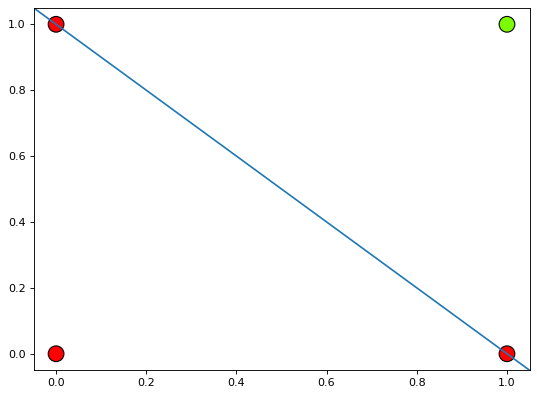

In [18]:
def line_from_state(state):
    "Get the function for the line encoded by the state"
    slope = -(state[0] / state[1])
    y_offset = -(state[2] / state[1])
    return lambda x : (x * slope) + y_offset
    
domain = np.arange(-2, 2, 0.01)
fig, axes = plt.subplots(figsize=(8, 6), dpi=80)
axes.set_xlim(-0.05, 1.05)
axes.set_ylim(-0.05, 1.05)
# generate points dataset
xvals = np.array([1, 1, 0, 0])
yvals = np.array([1, 0, 1, 0])
colors = np.array(['lawngreen', 'r', 'r', 'r'])
axes.scatter(xvals, yvals, c=colors, edgecolors='black', s=200)
line = line_from_state(and_log[-1])
axes.plot(domain, line(domain))
plt.show  

Can our perceptron discern the pattern indicated by the following graph? Can it learn that its output value should be $1$ iff exactly one of its inputs is $1$? Let's find out.

<function matplotlib.pyplot.show(close=None, block=None)>

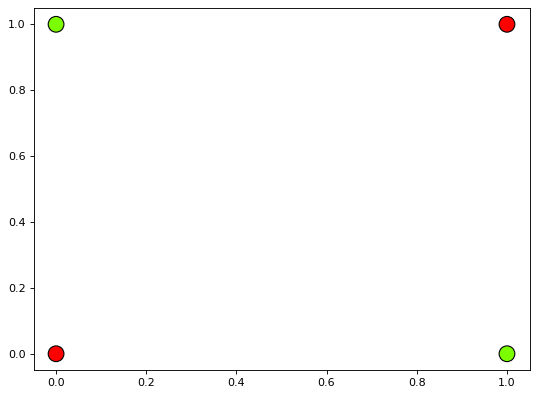

In [19]:
domain = np.arange(-2, 2, 0.01)
fig, axes = plt.subplots(figsize=(8, 6), dpi=80)
axes.set_xlim(-0.05, 1.05)
axes.set_ylim(-0.05, 1.05)
# generate points dataset
xvals = np.array([1, 1, 0, 0])
yvals = np.array([1, 0, 1, 0])
colors = np.array(['r', 'lawngreen', 'lawngreen', 'r'])
axes.scatter(xvals, yvals, c=colors, edgecolors='black', s=200)
plt.show  

In [20]:
def XOR(x, y):
    return 1 if ((x == 1 and y == 0) or (x == 0 and y == 1)) else 0

# Generate xor dataset
xor_inputs, xor_targets = binary_dataset(XOR, 1000)

# Train the perceptron on the xor dataset
xor_perceptron, xor_log = train_network(xor_inputs,
                                    initial_weight_1, 
                                    initial_weight_2,
                                    initial_bias,
                                    xor_targets,
                                    alpha)

# Output the results
truth_table(xor_perceptron)

,Input 1,Input 2,Output
,1,1,0
,1,0,1
,0,1,0
,0,0,0


As we anticipated, the perceptron appears to be incapable of learning this pattern since the pattern cannot be expressed as a linear separation. 

### Introduction to Gradient Descent

Before moving on to another example, let us try to understand the rationale behind the algorithm that we used to train our neural network. In particular, let us try to understand why we updated the weights and bias of the network in response to each data point as we did. For each data point $(x,y)$, we are given the vertical displacement of that point from the dividing line, denoted $l(x,y)$. This is the target quantity that we hoped that our neural network would be able to correctly predict. The actual prediction of the network was $o(x,y)$. How far off was this prediction from its target? 

There are many way of measuring predictive error, but one standard metric that is often employed is the square of the difference between the predicted value and its target, in this case:

$$
E(x,y) = (o(x,y)-l(x,y))^2
$$

Now, the goal, of course, is to make accurate predictions and that means that we want to adjust the state of the network so as to minimize the error $E(x,y)$. If we think of the internal state of the network, at a given time, as represented by a point in 3-dimensional space (with a $w_1$-component, a $w_2$-component, and a $b$-component), the question is: in what direction should I move this point in order to minimize the overall error. If you remember a bit of calculus, you know that the direction of maximal increase of the error is given by the gradient of the error function. This is the vector whose $w_1$-, $w_2$-, and $b$-components are given by the quantities $\frac{\partial E}{\partial w_1}$, $\frac{\partial E}{\partial w_2}$, and $\frac{\partial E}{\partial b}$, respectively. Now:

$$
\begin{eqnarray*}
\frac{\partial E}{\partial w_1} &=& \frac{\partial}{\partial w_1} \left(o(x,y)-l(x,y)\right)^2 \\
&=& 2(o(x,y)-l(x,y))\frac{\partial o(x,y)}{\partial w_1}  \\
&=& 2(o(x,y)-l(x,y))\frac{\partial}{\partial w_1}\left(x w_1 + y w_2 + b\right) \\
&=& 2x(o(x,y)-l(x,y)) \\
&=& 2x\Delta(x,y)
\end{eqnarray*}
$$
By similar reasoning, we have:
$$
\begin{eqnarray*}
\frac{\partial E}{\partial w_2} = 2y\Delta(x,y) \\
\end{eqnarray*}
$$

$$
\begin{eqnarray*}
\frac{\partial E}{\partial b} = 2\Delta(x,y) \\
\end{eqnarray*}
$$

So the gradient of the error function is given by the following vector:

$$
\langle x\Delta(x,y), y\Delta(x,y), \Delta(x,y)\rangle
$$

If we want to minimize error, we should adjust the state of the network by moving some amount in the *opposite* direction of the gradient. In other words, if we are currently at the point $\langle w_1, w_2,b\rangle$, then we want to move to a point $\langle w_1', w_2', b'\rangle$, where:

$$
\langle w_1', w_2', b'\rangle = \langle w_1, w_2,b\rangle - \alpha \langle x\Delta(x,y), y\Delta(x,y), \Delta(x,y)\rangle
$$

Expressed as separate equations for each of the three coordinates, we obtain our updating algorithm.

The lesson to take from this discussion is that updating a neural network with respect to a given data point means adjusting its internal state so as to minimize the predictive error of the network with respect to that data point. This means shifting the internal state of the network some amount in the direction opposite to the gradient of the error. How far in this direction we shift the state is determined by an independent parameter, $\alpha$, referred to as the 'learning rate'. If $\alpha$ is small, then each data point causes only a small adjustments in the internal state of the network. If $\alpha$ is large, then each data point precipitates a large adjustment in the internal state of the network. In real-world contexts, it is not always easy to know how to set this parameter, and an appropriate rate of learning must be ascertained through trial-and-error.

This general method of updating a neural network is referred to as the method of *gradient descent*. Next we will see how this method can be applied in the context of a real-world application. 

## Example 1: Learning to Recognize Handwritten Numerical Digits
### The MNIST Database of Handwritten Digits

The MNIST image dataset is a collection of grayscale images of handwritten numerical digits ($28$ pixels $\times$ $28$ pixels). We will represent these images as arrays of $784$ ($28 \times 28$) numbers, each in the interval $[0, 1]$, representing the grayscale color intensity of the corresponding pixel ($0 =$ white, $1 =$ black). The images are divided into two disjoint sets: a set of $60,000$ training images (stored in the variable `training_images`) and set of ($10,000$) testing images (stored in the variable `testing_images`). In addition, the MNIST database provides a corresponding set of labels, indicating, for each image in the dataset, which numerical digit it depicts (these sets of labels are stored in the variables `training_labels` and `testing_labels`).    

Here is a sample image of a handwritten digit from the dataset, along with its corresponding label.

This is an image of a handwritten 6


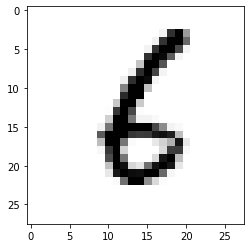

In [21]:
def display_image(image):
    """Displays an image"""
    image_2d = image.reshape(28, 28)
    plt.imshow(image_2d, interpolation='nearest', cmap='Greys')

def display_labeled_image(i):
    """Displays the ith training image with its corresponding label."""
    image = training_images[i]
    digit = training_labels[i]   
    
    print(f"This is an image of a handwritten {digit}")
    display_image(image)
    
display_labeled_image(2372)

## Designing the Neural Network
Let us implement a simple neural network that can be used to identify the numerals depicted by images of handwritten digits, such as those which are stored in the MNIST dataset. As before, our neural network will consist of an input layer of neurons and an output layer of neurons. The network will be fully connected in the sense that every input neuron will be connected to every output neuron. The graph of such a fully connected 2-layer neural network is pictured below:

![nn_simple](../assets/images/mnist/nn_simple.png)

The state of such a neural network is given by an assignment of weights to each of the links connecting the neurons (in this case, we'll ignore the bias). The neural network that we will use to classify the images in the MNIST dataset will contain $784$ neurons in the input layer (one for each pixel in a given image) and $10$ neurons in the output layer (one for each of the numerical digits $0,\ldots,9$). In training the network, our aim will be to adjust the weights so that any image of a handwritten digit, encoded as a sequence of $784$ input values, is transformed into a sequence of $10$ output values from which we can reliably infer what numerical digit is depicted in the image.  

### Applying the Method of Gradient Descent to our Neural Network

The method by which our neural network will be trained is the method of gradient descent, we will take as given:

1. An ordered set of *inputs* on which the network will be trained, referred to as *training inputs*. Each training input assigns a numerical value to every neuron in the input layer.
2. An ordered set of *targets*, one for each training input, referred to as *training targets*. Each training target assigns a numerical value to every neuron in the output layer.


The specific method by which we will train the network is referred to as the method of *gradient descent*. We will first describe this method as it applies to any 2-layer neural network (while the basic idea behind the method is always the same, as we shall see, the details of its implementation are somewhat more involved when the method is applied to networks with more complex architectures). To describe the method precisely, it will be helpful to adopt the following notation:

1. $T$ is the number of training inputs (and training targets); $N_0$ is the number of neurons in the network's input layer; and $N_1$ is the number of neurons in the network's output layer. 

For $t=0,\ldots,T-1$:

2. $v^{t} = [v^{t}_0,\ldots, v^{t}_{N_0-1}]$, where $v^{t}_i = $ the value assigned to the $i^{\mathrm{th}}$ neuron in the input layer by the $t^{\mathrm{th}}$ training input.  
3. $l^{t} = [l^{t}_0,\ldots, l^{t}_{N_1-1}]$, where $l^{t}_i = $ the value assigned to the $i^{\mathrm{th}}$ neuron in the output layer by the $t^{\mathrm{th}}$ training target
4. $w^{t}$ is the matrix:

$$
\begin{bmatrix}
        w^t_{00} & w^t_{01} & \cdots & w^t_{0(N_1-1)}\\
        w^t_{10} & w^t_{11} & \cdots & w^t_{1(N_1-1)}\\
        \vdots & \vdots & \ddots & \vdots\\
        w^t_{(N_0-1)0} & w^t_{(N_0-1)1} & \cdots & w^t_{(N_0-1)(N_1-1)}\\
        \end{bmatrix}
$$
             
where $w^t_{ij}=$ the weight of the link connecting the $i^{\mathrm{th}}$ neuron in the input layer to the $j^{\mathrm{th}}$ neuron in the output layer at the point at which the network is trained on the $t^{\mathrm{th}}$ training input.

We  update the weights of the network by successively feeding each training input to the network and comparing the output to the corresponding training target. The specific updating process with respect to a given training input can be described as follows:

1. **Propagate the $t^{\mathrm{th}}$ training input through the network.** This means that the values of the neurons in the output layer are set to the weighted averages (dot product) of the values of the neurons in the input layer. Formally, if $o^{t} = [o^{t}_0,\ldots, o^{t}_{N_1-1}]$, where $o^{t}_i = $ the value assigned to the $i^{\mathrm{th}}$ neuron in the output layer by propagating the $t^{\mathrm{th}}$ training input through the network, then $o^t = v^t\cdot w^t$, i.e.:
$$ 
    o^t_i = \sum_{j=0}^{N_0-1} v^t_j w^t_{ji} 
$$


In [22]:
def propagate(weights, inputs):
    """Propagate inputs through the neural network"""
    # Return the dot product of the inputs and the weights (i.e., the weighted averages of the inputs) 
    outputs = np.dot(inputs, weights)
    return outputs

2. **Measure the degree of error (or "loss") of the outputs from the corresponding training target**. While there are many different ways of measuring the extent to which the outputs deviate from the corresponding training target, one standard loss function is the mean-squared error, given by:
$$
E(o^t) = \frac{1}{N_1}(o^t - l^t)^2 = \frac{1}{N_1}\sum_{i=0}^{N_1-1} (o^t_i - l^t_i)^2
$$

3. **Adjust the network weights by some amount in the opposite direction of the gradient of the loss function.** Since the gradient of a multi-variate function points in the direction in which that function increases most rapidly, by shifting the weights in a direction opposite to that of the gradient of the loss function, the result should be that the output's loss (at least for that specific training input) is decreased. If we view $E$ as a function of the network weights, then the $w^t_{ij}$-component of the gradient of $E$ is given by the partial derivative of $E$ with respect to $w^t_{ij}$:

$$
\begin{eqnarray}
    \frac{\partial E}{\partial w^t_{ij}} &=& \frac{\partial}{\partial w^t_{ij}}\left\{\frac{1}{N_1}\sum_{n=0}^{N_1-1} (o^t_n - l^t_n)^2\right\} \\
                                        &=& \frac{\partial}{\partial w^t_{ij}}\left\{\frac{1}{N_1}\sum_{n=0}^{N_1-1} \left(\left(\sum_{m=0}^{N_0-1} v^t_m w^t_{mn}\right) - l^t_n\right)^2\right\} \\
                                        &=& \frac{\partial}{\partial w^t_{ij}}\left\{\frac{1}{N_1}\left(\left(\sum_{m=0}^{N_0-1} v^t_m w^t_{mj}\right) - l^t_j\right)^2\right\}\\
                                        &=& \frac{2v^t_i}{N_1}\left(\left(\sum_{m=0}^{N_0-1} v^t_m w^t_{mj}\right) - l^t_j\right) \\
                                        &=& \frac{2v^t_i}{N_1}\left(o^t_j - l^t_j\right) \\
\end{eqnarray}
$$

Thus, the $w^t_{ij}$-component of the gradient of the error function is proportional to:
$$v^t_i\left(o^t_j - l^t_j\right)$$
To adjust the weights in the direction opposite to the gradient means to *subtract* from each weight some fixed positive multiple of this quantity, i.e.: 
$$
w^{t+1}_{ij} = w^t_{ij} - \alpha v^t_i\left(o^t_j - l^t_j\right)
$$
where $\alpha$ is a positive constant, referred to as the *learning rate*. These equations, which describes the gradient descent algorithm for updating the weights in response to the $t^{\mathrm{th}}$ training input, can be summarized by the following equation, expressed in matrix notation:
$$
w^{t+1} = w^t - \alpha \left((v^t)^{\top}\cdot(o^t-l^t)\right)
$$
where $(v^t)^{\top}$ is the vector transpose of $v^t$, i.e.:

$$
(v^t)^{\top} = \begin{bmatrix}
               v^t_0 \\
               v^t_1 \\
               \vdots \\
               v^t_{N_0-1}
             \end{bmatrix}
$$
The following code implements this algorithm.

In [23]:
def update_mnist_network(weights, inputs, targets, alpha):
    """Update weights using gradient descent wrt mean squared loss function"""
    # Propagate the inputs throught the network
    outputs = propagate(weights, inputs)
    # Compute the gradient (scaled by alpha)
    scaled_gradient = alpha * (inputs.T.dot(outputs - targets))
    # Adjust the weights by subtracting the scaled gradient
    weights -= scaled_gradient

    return weights

4. **Repeat steps 1-4 for the $(t+1)^{th}$ training input.** Training the network consists in updating the weights by successively applying the gradient descent algorithm to each of the training inputs. In other words, given initial weights, $w^0$, the training process returns a neural network with weights, $w^T$, obtained through the repeated application of the gradient decent algorithm.


In [24]:
def train_mnist_network(initial_weights, training_inputs, training_targets, alpha):
    """Train the neural network using the method of gradient descent"""
    # Initialize weights
    weights = initial_weights
    # Update weights for each training input
    for t in range(len(training_inputs)):
        inputs = training_inputs[t]
        targets = training_targets[t]
        weights = update_mnist_network(weights, inputs, targets, alpha)
        
    def trained_network(inputs):
        return np.dot(inputs, weights)
    
    # Return the trained neural network and its weights
    return trained_network, weights          

### Training and Testing the MNIST Neural Network

We are now in a position to train a neural network that we can use to identify the digits depicted in the images in the MNIST dataset. As noted above, the network will contain $784$ input neurons (one for each pixel in a given image) and $10$ output neurons (one for each of the numerical digits $0,\ldots,9$). The training inputs for the network will consist of the $60,000$ images comprising the `training_images` dataset. The training targets will consist of the corresponding labels, stored as arrays of length $10$ where every entry is $0$ except for the entry whose index is the depicted digit, which will be $1$ (e.g., the target corresponding to an image of the digit $4$ will be $[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]$). For simplicity, the training targets have already been saved in the variable `training_targets`.

For the initial weights, we will use random numbers in the interval $[−0.1,0.1]$ and we will use a learning rate of $0.005$. 

In [25]:
# Generate random weights between -0.1 and 0.1
random_weights = 0.2 * np.random.rand(784, 10) - 0.1

# Train the neural network - THIS TAKES TIME
mnist_neural_network, weights = train_mnist_network(random_weights, training_images, training_targets, 0.005)

We now have a neural network that has been trained on the $60,000$ images in MNIST dataset. Let's test the network on a sample image from the dataset to see what output it produces.

     Output  Target
0  0.115848     0.0
1 -0.283348     0.0
2  0.172124     0.0
3 -0.070472     0.0
4  0.032625     0.0
5 -0.013518     0.0
6  0.933782     1.0
7  0.052321     0.0
8  0.257914     0.0
9  0.020050     0.0


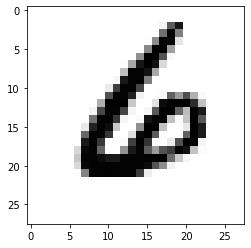

In [26]:
image = training_images[2345]
targets = training_targets[2345]

def display_output(outputs, targets):
    """Display the neuron values for a layer of the neural network"""
    vals = {'Output': outputs.flatten(), 'Target': targets.flatten()}
    output_table = pd.DataFrame(vals)
    print(output_table)
    
# Propagate the image through the network
outputs = mnist_neural_network(image)
# Display the values of the output neurons
display_output(outputs, targets)
# Display the input image
display_image(image)

The output from the neural network is displayed above the sample image, which depicts the numerical digit $6$. Notice that while the produced output is still quite far from the target output, it does capture the target output's most important feature, viz., the neuron in position $6$ in the output layer is the one with the largest numerical value. Let us appeal to this property of the output of the neural network to see how well the network can identify the handwritten digits depicted by the images in the MNIST dataset. To test the neural network, we will ask it to identify the numbers depicted by the $10,000$ images in the dataset `testing_images`, which were not used to train the network.  

In [27]:
def identify_digit(network, image):
    """Use a neural network to identify the handwritten digit depicted in an image"""
    outputs = network(image)
    # Return the neural network's prediction of the digit depicted in the image (the function "np.argmax" returns the index of the largest value in the argument array).
    return np.argmax(outputs)


def test_mnist_network(network):
    # Total number of correct ids
    correct = 0 
    for i in range(len(testing_images)):
        image = testing_images[i]
        digit = testing_labels[i]
        prediction = identify_digit(network, image)
        # If the neural network correctly ids the digit, add 1 to the number of correct guesses. If not, do nothing.
        if (prediction == digit):
            correct += 1
    
    # Print the results
    print(f"The neural network identified {correct}/10000 ({round((correct / 10000) * 100, 2)}%) of the images correctly.") 
    
test_mnist_network(mnist_neural_network)

The neural network identified 7701/10000 (77.01%) of the images correctly.


## What is Machine Learning?



There is an important difference between the two applications of neural networks that we have considered so far. In the first example of linear regression using a displacement map, the data that we trained our network on was itself generated algorithmically by means of a simple computer program. In this sense, the task that we trained our neural network to perform (viz., predicting the vertical displacement of a point from a fixed dividing line) was not only a task that we already knew how to accomplish, but also a task that we knew how to *instruct* a computer to accomplish. Thus, what the neural network had to learn to do by analyzing the data  was something that we ourselves could have instructed it how to do just by writing a simple program. 

This is clearly not the case in the second example. While we are all certainly capable of judging which numeral is represented by a handwritten image of the sort that is stored in the MNIST database, we have no idea how to give a computer instructions (in the form of a computer program) for how to calculate from the grayscale color intensity of a pixel map what numeral is depicted in the image. We might start by saying if you find a closed circle somewhere on the image, then rule out the numerals 1, 3, 4, 5, and 7, but then we would have to explain to the computer, in the first place, how to algorithmically identify circles on the image in a way that is tolerant enough to allow for the geometrical variation that is characteristic of human handwriting, but strict enough to distinguish a circular figure from, say, the closed triangular figure that might appear in the image of a handwritten 4. We might then, try to give additional instructions that could help to filter down the possible options further, until a unique prediction could be made. But, obviously, to even begin to produce such a program would require a highly detailed theoretical understanding of human handwriting that could only be obtained by a careful examination and comparison of many examples. Even then, it is unclear how accurate our instructions would be. Even a phenomenon as basic as the decoding of human handwriting is, from a theoretical perspective, an incredibly messy phenomenon - much more so than, say, predicting the motions of the stars in the sky. 

What is rather remarkable about the little program that we have just written is that, in only a few lines of code, we have managed to make some progress in overcoming this theoretical obstacle. We did so not by instructing our neural network how to decode handwritten numerals (which we couldn't have done even if we wanted to), but rather by instructing it how to examine some data and *learn* from that data how to perform the task for itself. This programming paradigm is referred to as 'machine learning'. When we write a machine learning program, we do not provide a computer with a set of instructions for performing the task that we would ultimately like it to perform. Instead, we provide it with a set of instructions for how to *learn* to do the task on its own (usually under the supervision of a curated dataset of training targets, but not always). Neural networks are one framework for composing machine learning programs that has proven to be remarkably successful across a wide variety of narrow AI applications. 

An interesting question that we might raise at this point is: now that the neural network knows, for itself, how to identify handwritten digits with a reasonable degree of accuracy, can we have it explain to us what instructions it is following? That is, can we have it teach *us* what it has come to learn about the the theory of human handwriting. In the case of the simple neural network that we have designed, we can in fact glean some insight into this theory by examining the internal state of the trained network. Essentially, the network is looking for correlations between the grayscale intensity of certain pixels and the probability of those pixels displaying a certain numeral. So, by looking at the weights of the trained network, we can gain some insight into the nature of these correlations. 

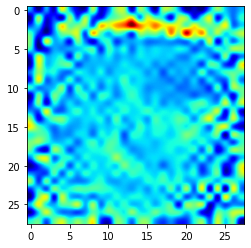

In [30]:
# Express the array of weights connecting the input neurons to a specific output neuron as a 2-d array.  
weight_maps = [[] for i in range(10)]
for number in range(10):
    for px in range(784):
        weight_maps[number].append(weights[px][number])
        
weight_maps = [np.array(weight_maps[i]) for i in range(10)] # IGNORE THIS LINE

def display_correlation_map(number):
    """Display the weights connecting the input neurons to a specific output neuron as a correlational heat map"""
    correlation_map = np.array([weight_maps[number][i * 28: (i + 1) * 28] for i in range(28)])
    plt.imshow(correlation_map, interpolation='catrom', cmap='jet')

display_correlation_map(6)


## Solving the XOR Problem by 'Going Deep'

Let us return, for a moment, to the XOR problem. Recall that a simple perceptron with two input neurons and one output neuron is incapable of detecting the pattern XOR in a binary dataset. The reason is because the architecture of the network (i.e., its propagation algorithm) is only capable of 'expressing' linear separations, and, as we have seen, the XOR pattern cannot be expressed in this way. But, as the following code confirmed, the perceptron is capable of discerning the patterns corresponding to many other binary operations, like AND ($1$ iff both of the inputs is $1$, OR ($1$ iff either of the inputs is $1$), and NAND ($1$ iff either of the inputs is $0$):   

In [35]:
def propagate(input_1, input_2, weight_1, weight_2, bias):
    """Propagate input values through the perceptron"""
    return 1 if ((input_1 * weight_1) + (input_2 * weight_2) + bias > 0) else 0

In [36]:
def AND(x, y):
    return 1 if (x == 1 and y == 1) else 0

# Generate and dataset
and_inputs, and_targets = binary_dataset(AND, 100)

# Train the perceptron on the or dataset
and_perceptron, and_log = train_network(and_inputs,
                                        initial_weight_1, 
                                        initial_weight_2,
                                        initial_bias,
                                        and_targets,
                                        alpha)

# Output the results
truth_table(and_perceptron)

,Input 1,Input 2,Output
,1,1,1
,1,0,0
,0,1,0
,0,0,0


In [37]:
def OR(x, y):
    return 1 if (x == 1 or y == 1) else 0

# Generate or dataset
or_inputs, or_targets = binary_dataset(OR, 100)

# Train the perceptron on the or dataset
or_perceptron, or_log = train_network(or_inputs,
                                      initial_weight_1, 
                                      initial_weight_2,
                                      initial_bias,
                                      or_targets,
                                      alpha)

# Output the results
truth_table(or_perceptron)

,Input 1,Input 2,Output
,1,1,1
,1,0,1
,0,1,1
,0,0,0


In [38]:
def NAND(x, y):
    return 0 if (x == 1 and y == 1) else 1

# Generate nand dataset
nand_inputs, nand_targets = binary_dataset(NAND, 100)

# Train the perceptron on the nand dataset
nand_perceptron, nand_log = train_network(nand_inputs,
                                          initial_weight_1, 
                                          initial_weight_2,
                                          initial_bias,
                                          nand_targets,
                                          alpha)

# Output the results
truth_table(nand_perceptron)

,Input 1,Input 2,Output
,1,1,0
,1,0,1
,0,1,1
,0,0,1


Now, if our network were capable of expressing compositions of these (expressible) patterns, then it would be capable of expressing the XOR pattern as well, since:

$$
\textrm{XOR}(x, y) = \textrm{AND}(\textrm{OR}(x,y), \textrm{NAND}(x,y))
$$

So, how can we build a network that is capable of composing the patterns expressible by a perceptron? The most obvious answer to this question is to compose the perceptrons themselves. For example, to implement a network capable of expressing the pattern XOR, we could use three perceptrons. The first two perceptrons should receive the same inputs and should be OR and NAND perceptrons, respectively. Their outputs should then feed into a third AND perceptron. The structure of such a multi-perceptron network is as follows: 

![2nn_2_2_1](../assets/images/mnist/2nn_2_2_1.png)

Its output would yield the pattern XOR:

In [196]:
def xor_multi_perceptron(input_1, input_2):
    return and_perceptron(nand_perceptron(input_1, input_2), or_perceptron(input_1, input_2))

truth_table(xor_multi_perceptron)

,Input 1,Input 2,Output
,1,1,0
,1,0,1
,0,1,1
,0,0,0


Note that an equivalent way to denote the structure of this network is as follows: 

![dnn_2_2_1](../assets/images/mnist/dnn_2_2_1.png)

We know that this multi-layer (or 'deep') perceptron is capable of expressing the pattern XOR. But the question is how to train the network to do so by analyzing the XOR data. This, it turns out, is a very difficult problem, for the updating algorithm for the single perceptron does not generalize in a straightforward way to the multi-perceptron case. This, in fact, is the problem that stalled the original research program into AI systems with neural network architectures. The difficulty stems from the following two features of the above multi-perceptron:

1. This perceptron is much more expressive, in term of the patterns it can detect, than the single-layer perceptron discussed earlier. Consequently, in order to hit upon the XOR pattern, much more gradual adjustments in the internal state of the network are required at each stage of the updating.   

2. Because the output of each of the three single-layer perceptrons comprising the network is based on a threshold (i.e., all-or-nothing) activation, small adjustments in any direction of the internal state of the network will have no corresponding effect at all on the network's output. In mathematical terms, this means that the error gradient of the network is zero almost everywhere in the state space of the network. Consequently,  we cannot use the method of gradient descent to guide our adjustments of the network's internal state. 

In combination, these two properties of the multi-perceptron make it very difficult to train. To overcome this difficulty, two adjustments must be made. First, the all-or-nothing (digital) activation of the neurons in the middle layer of the network, has to be replaced with an analog approximation, so that the method of gradient descent can be effectively applied. Here is an example of an analog activation function that is commonly used: 

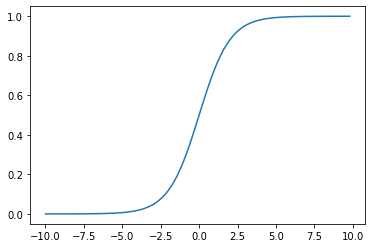

In [78]:
def sigmoid(x):
    """Analog Appoximation to Digital Threshold Activation"""
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

domain = np.arange(-10., 10., 0.2)
plt.plot(domain, sigmoid(domain))
plt.show()

The propagation algorithm for a perceptron in which the usual threshold activation has been replaced by this analog approximation is:

In [79]:
def propagate(perceptron, input_1, input_2):
    weight_1, weight_2, bias = perceptron
    return sigmoid((input_1 * weight_1) + (input_2 * weight_2) + bias)

The following code implements the training protocol (using the method of gradient descent) for the analog version of the multi-perceptron network described above (don't worry about the details):  

In [80]:
def update_perceptron(perceptron, input_1, input_2, error, alpha):
    weight_1, weight_2, bias = perceptron
    weight_1 -= alpha * input_1 * error
    weight_2 -= alpha * input_2 * error
    bias -= alpha * error
    return [weight_1, weight_2, bias]

def update_network(network, input_1, input_2, target, alpha):
    p1, p2, p3 = network
    hidden_input_1 = propagate(p1, input_1, input_2)
    hidden_input_2 = propagate(p2, input_1, input_2)
    output = propagate(p3, hidden_input_1, hidden_input_2)
    
    delta = (output - target) 
    error = delta * sigmoid_derivative(output)
    
    ## Backpropagation
    weight_1, weight_2, bias = p3
    hidden_delta_1 = error * weight_1
    hidden_error_1 = (hidden_delta_1) * sigmoid_derivative(hidden_input_1)
    hidden_delta_2 = error * weight_2
    hidden_error_2 = (hidden_delta_2) * sigmoid_derivative(hidden_input_2)
    
    p1 = update_perceptron(p1, input_1, input_2, hidden_error_1, alpha)
    p2 = update_perceptron(p2, input_1, input_2, hidden_error_2, alpha)
    p3 = update_perceptron(p3, hidden_input_1, hidden_input_2, error, alpha)
    
    ## Return updated state
    return [p1, p2, p3]
    
def train_network(training_inputs, initial_state, training_targets, alpha):
    """Train the neural network using the training algorithm"""
    # Initialize network
    network = initial_state
    
    # Update weights and bias for each training input
    for t in range(len(training_inputs)):
        input_1 = training_inputs[t][0]
        input_2 = training_inputs[t][1]
        target = training_targets[t]
        # update the network 
        network = update_network(network, input_1, input_2, target, alpha)
        
    # The fully trained network
    def trained_network(input_1, input_2):
        p1, p2, p3 = network
        hidden_input_1 = propagate(p1, input_1, input_2)
        hidden_input_2 = propagate(p2, input_1, input_2)
        return propagate(p3, hidden_input_1, hidden_input_2)
    
    # Return the trained neural network and the training log
    return trained_network, network  

The second adjustment that is needed is that the training of the network must proceed in a more gradual fashion. In other words the learning rate must be decreased and the network must be trained on a larger dataset. The need for this owing to the fact that, given the expressiveness of the network, the XOR solution (and its close approximations) occupy a smaller region of the network's state space and are thus more difficult to find.

In [90]:
initial_state = [[random.random() for i in range(3)] for j in range(3)]
alpha = 0.1

# Generate nand dataset
xor_inputs, xor_targets = binary_dataset(XOR, 75000)

xor_deep_perceptron, state = train_network(xor_inputs, initial_state, xor_targets, alpha)
truth_table(xor_deep_perceptron)

,Input 1,Input 2,Output
,1,1,0.033123
,1,0,0.969267
,0,1,0.969432
,0,0,0.034999
